In [1]:
import moscot as mt
import moscot.plotting as mtp
from moscot.problems.time import TemporalProblem
import scanpy as sc
import numpy as np
import jax
import sklearn.preprocessing as pp

In [2]:
adata = sc.read("../../data/adata_pancreas_2019.h5ad")

In [3]:
adata = adata[adata.obs["celltype"]!="Multipotent"].copy()
adata.obs["lineage"] = adata.obs.apply(lambda x: "A" if x["celltype"] in ["Acinar", "Tip"] else "ED", axis=1).astype("category")

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


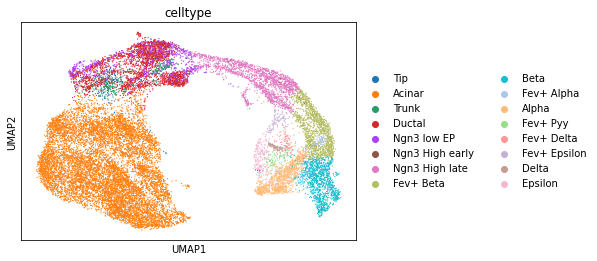

In [4]:
sc.pl.umap(adata, color="celltype")

In [5]:
sc.pp.pca(adata, n_comps=30)
adata.obsm["X_pca_scaled"] = pp.StandardScaler().fit_transform(adata.obsm["X_pca"])

In [6]:
n_cells_source=len(adata[adata.obs["day"]=="14.5"])
n_cells_target=len(adata[adata.obs["day"]=="15.5"])

n_samples_train_source = int(n_cells_source * 0.6)
n_samples_test_source = n_cells_source - n_samples_train_source

n_samples_train_target = int(n_cells_target * 0.6)
n_samples_test_target = n_cells_target - n_samples_train_target

inds_source_train = np.asarray(jax.random.choice(jax.random.PRNGKey(0), n_cells_source, (n_samples_train_source,), replace=False))
inds_source_test = list(set(list(range(n_samples_train_source))) - set(inds_source_train))

inds_target_train = np.asarray(list(jax.random.choice(jax.random.PRNGKey(1), n_cells_target, (n_samples_train_target,), replace=False)))
inds_target_test = list(set(list(range(n_samples_train_target))) - set(inds_target_train))

adata_source_train = adata[adata.obs["day"]=="14.5"][inds_source_train,:]
adata_source_test = adata[adata.obs["day"]=="14.5"][inds_source_test,:]

adata_target_train = adata[adata.obs["day"]=="15.5"][inds_target_train,:]
adata_target_test = adata[adata.obs["day"]=="15.5"][inds_target_test,:]

source_train = adata_source_train.obsm["X_pca_scaled"]
source_test = adata_source_test.obsm["X_pca_scaled"]
target_train = adata_target_train.obsm["X_pca_scaled"]
target_test = adata_target_test.obsm["X_pca_scaled"]

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
2023-09-18 10:17:05.960556: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.140). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
bdata = sc.concat(
    [adata_source_train, adata_target_train],
    join="outer",
    label="day",
    keys=[14.5, 15.5],
)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):


In [8]:
tp = TemporalProblem(bdata)
tp = tp.prepare("day", joint_attr="X_pca")
tp = tp.solve(epsilon=1e-2, scale_cost="mean", tau_a=1.0, tau_b=1.0)

INFO     Ordering Index(['GGAAAGCTCTTCTGGC-1-2', 'TTTGGTTAGCTGGAAC-1-2', 'GCACTCTTCACGATGT-1-2',                   
                'TCAACGATCTCCTATA-1-2', 'GCGGGTTGTGTAATGA-1-2', 'ATAACGCCAGCCTTTC-1-2',                            
                'TACTTACTCAAACGGG-1-2', 'CTCGAGGGTTCGTGAT-1-2', 'TTCCCAGTCTAAGCCA-1-2',                            
                'TCGGTAAAGTAGGTGC-1-2',                                                                            
                ...                                                                                                
                'TGCCCTAAGGCCCTCA-1-3', 'CTGTGCTGTCTAGGTT-1-3', 'TCGGTAATCTGTTGAG-1-3',                            
                'TCTGAGATCACGCGGT-1-3', 'TACGGATCATTCCTCG-1-3', 'AGAGTGGGTTCTGTTT-1-3',                            
                'CGTCTACAGCAAATCA-1-3', 'CACATTTTCCTCAACC-1-3', 'TGAGAGGCAAGCTGAG-1-3',                            
                'CTCCTAGGTTCAGTAC-1-3'],                                

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/moscot/problems/time/_mixins.py:986: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not (is_categorical_dtype(col) and is_numeric_dtype(col.cat.categories)):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [9]:
def aggregate_transport_matrix(adata_source, adata_target, tmat, aggregation_key = "celltype", forward = True):
    df_source = adata_source.obs[aggregation_key]
    df_target = adata_target.obs[aggregation_key]

    annotations_source = adata_source.obs[aggregation_key].cat.categories
    annotations_target = adata_target.obs[aggregation_key].cat.categories

    tm = pd.DataFrame(
        np.zeros((len(annotations_source), len(annotations_target))),
        index=annotations_source,
        columns=annotations_target,
    )
    
    for annotation_src in annotations_source:
        for annotation_tgt in annotations_target:
            tm.loc[annotation_src, annotation_tgt] = tmat[
                np.ix_((df_source == annotation_src).squeeze(), (df_target == annotation_tgt).squeeze())
            ].sum()
    return tm

In [10]:
import pandas as pd
agg_tm = aggregate_transport_matrix(bdata[bdata.obs["day"]==14.5], bdata[bdata.obs["day"]==15.5], tp[14.5, 15.5].solution.transport_matrix, aggregation_key="lineage")
agg_tm

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


,A,ED
A,0.354485,0.000047
ED,0.299723,0.345745


In [11]:
print((agg_tm.iloc[0,0]+agg_tm.iloc[1,1])/agg_tm.sum().sum())

0.7002296257812786


In [12]:
adata_source_train.obs["left_reweighting"] = tp[14.5, 15.5].solution.a*len(tp[14.5, 15.5].solution.a)
adata_target_train.obs["right_reweighting"] = tp[14.5, 15.5].solution.b*len(tp[14.5, 15.5].solution.b)

/tmp/ipykernel_2876688/4143016419.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_source_train.obs["left_reweighting"] = tp[14.5, 15.5].solution.a*len(tp[14.5, 15.5].solution.a)
/tmp/ipykernel_2876688/4143016419.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_target_train.obs["right_reweighting"] = tp[14.5, 15.5].solution.b*len(tp[14.5, 15.5].solution.b)


In [13]:
adata_source_train.obs.to_csv("pancreas_unbalanced_100_discrete_left.csv")
adata_target_train.obs.to_csv("pancreas_unbalanced_100_discrete_right.csv")